## 📖 Latar Belakang

### 🟦 1. Multi-Scale Retinex (MSR)

Teori Retinex memodelkan citra sebagai kombinasi antara reflektansi dan iluminasi:

\[
I(x,y) = R(x,y) \cdot L(x,y)
\]

dengan:
- \( I(x,y) \) → citra pengamatan  
- \( R(x,y) \) → reflektansi (informasi objek)  
- \( L(x,y) \) → iluminasi (pencahayaan)

Tujuan Retinex adalah memperkirakan \( R(x,y) \) dengan cara mengurangi pengaruh \( L(x,y) \).

Multi-Scale Retinex (MSR) menghitung hasil peningkatan citra dengan:

\[
MSR(x,y) = \sum_{i=1}^{N} w_i \left[ \log(I(x,y)) - \log(I(x,y) * G_{\sigma_i}) \right]
\]

di mana:
- \( G_{\sigma_i} \) adalah Gaussian blur dengan skala (σ) berbeda  
- \( N \) adalah jumlah skala  
- \( w_i \) adalah bobot tiap skala  

**Kelebihan MSR:**
- Meningkatkan kontras lokal dan global  
- Memperjelas detail pada daerah gelap dan terang  

**Kekurangan MSR:**
- Rentan meningkatkan noise  
- Dapat menimbulkan artefak halo di sekitar tepi objek  
- Warna dapat terlihat tidak natural akibat operasi logaritmik

---

### 🟩 2. MSR dengan Guided Filtering (MSR-GF)

**MSR-GF** adalah pengembangan MSR yang menggunakan **estimasi iluminasi yang lebih halus dan edge-aware** melalui kombinasi:

1. **Gaussian filtering multi-skala**  
   - Menghasilkan *rough illumination* pada beberapa tingkat smoothing.

2. **Guided filtering**  
   - Menghasilkan *edge-preserving illumination* yang halus namun tetap mempertahankan struktur tepi.

Alur besarnya:

1. Konversi citra ke grayscale untuk memodelkan iluminasi.  
2. Terapkan Gaussian blur pada beberapa skala (σ kecil, sedang, besar).  
3. Haluskan estimasi iluminasi dengan guided filter menggunakan citra asli sebagai *guide*.  
4. Gabungkan seluruh skala dengan bobot adaptif (misalnya berbasis kekuatan gradien/tepi).  
5. Terapkan Retinex menggunakan iluminasi hasil kombinasi tersebut.  
6. Normalisasi dan lakukan *color balance* sederhana.

**Keuntungan MSR-GF dibanding MSR klasik:**
- Iluminasi lebih halus dan tidak terlalu agresif  
- Noise lebih terkontrol  
- Artefak halo berkurang  
- Detail tetap terjaga, terutama pada citra remang dan gelap  

MSR-GF menjadi kompromi yang baik antara peningkatan pencahayaan dan preservasi struktur lokal citra.

---

## 🎚 3. Metrik Kualitas Citra No-Reference

Karena dataset yang digunakan merupakan **dataset primer tanpa ground truth**, metrik seperti PSNR dan SSIM **tidak dapat digunakan**.  
Sebagai gantinya, digunakan dua metrik *no-reference* yang populer:

---

### ⭐ BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator)

**BRISQUE** mengevaluasi kualitas citra berdasarkan:

- statistik spasial lokal,  
- deteksi distorsi seperti blur, noise, kompresi, dan gangguan tekstur.

BRISQUE menggunakan fitur **Natural Scene Statistics (NSS)** dan memetakan fitur tersebut ke skor kualitas menggunakan model yang telah dilatih sebelumnya.

**Interpretasi BRISQUE:**
- Nilai **lebih rendah** → kualitas citra **lebih baik**  
- Nilai **mendekati 0** → kualitas sangat baik  
- Rentang umum: **0–100** (meski nilai bisa negatif tergantung implementasi)

BRISQUE sensitif terhadap perubahan tekstur dan noise, sehingga sangat cocok untuk mengevaluasi efek samping dari metode peningkatan citra seperti MSR.

---

### ⭐ NIQE (Natural Image Quality Evaluator)

**NIQE** mengukur seberapa jauh sebuah citra menyimpang dari distribusi statistik citra alami berkualitas tinggi.

Karakteristik NIQE:
- Tidak memerlukan pelatihan khusus pada dataset distorsi tertentu (*training-free*).  
- Menggunakan model statistik dari citra alami sebagai referensi.

**Interpretasi NIQE:**
- Nilai **lebih rendah** → citra lebih natural / lebih berkualitas  
- Nilai **lebih tinggi** → citra semakin jauh dari citra alami

Perbedaan utama dengan BRISQUE:
- **NIQE** → menilai kualitas **global** (naturalness, distribusi intensitas, kontras, struktur besar)  
- **BRISQUE** → menilai kualitas **lokal** (noise, tekstur, artefak)

In [1]:
import os
import time
from pathlib import Path
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import pyiqa

c:\Users\albia\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ================================================================
# 1. Setup device dan metric kualitas (NIQE & BRISQUE dari pyiqa)
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Buat metric sekali saja (bisa dipakai berulang)
niqe_metric = pyiqa.create_metric("niqe", device=device)
brisque_metric = pyiqa.create_metric("brisque", device=device)

Using device: cuda


In [22]:
# ================================================================
# 2. Helper: konversi BGR (OpenCV) -> tensor PyTorch [0,1] RGB dan color balance
# ================================================================
def img_bgr_to_tensor(img_bgr: np.ndarray, device: torch.device = device) -> torch.Tensor:
    """
    img_bgr : numpy array (H, W, 3), BGR, uint8 [0, 255]
    return  : torch tensor (1, 3, H, W), RGB, float32 [0, 1] di device
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.0
    t = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).to(device)
    return t


def compute_niqe(img_bgr: np.ndarray) -> float:
    """Hitung NIQE no-reference dengan pyiqa dari gambar BGR (cv2)."""
    img_t = img_bgr_to_tensor(img_bgr, device)
    with torch.no_grad():
        score = niqe_metric(img_t)
    return float(score.item())


def compute_brisque(img_bgr: np.ndarray) -> float:
    """Hitung BRISQUE no-reference dengan pyiqa dari gambar BGR (cv2)."""
    img_t = img_bgr_to_tensor(img_bgr, device)
    with torch.no_grad():
        score = brisque_metric(img_t)
    return float(score.item())

def simple_color_balance(img_bgr: np.ndarray, low_clip: float = 2, high_clip: float = 98) -> np.ndarray:
    """
    Color balance sederhana per channel berdasarkan percentile.
    low_clip, high_clip: persen (0–100).
    """
    result = np.zeros_like(img_bgr, dtype=np.float32)
    for ch in range(3):
        channel = img_bgr[:, :, ch].astype(np.float32)
        lo = np.percentile(channel, low_clip)
        hi = np.percentile(channel, high_clip)
        if hi <= lo:
            # kalau percentilenya aneh, skip normalisasi channel ini
            result[:, :, ch] = channel
            continue
        ch_clip = np.clip(channel, lo, hi)
        ch_norm = (ch_clip - lo) / (hi - lo)
        result[:, :, ch] = ch_norm * 255.0

    return result.clip(0, 255).astype(np.uint8)

In [4]:
# ================================================================
# 3. MSR klasik (tanpa guided filter) - baseline
# ================================================================
def single_scale_retinex_basic(channel: np.ndarray, sigma: float, max_kernel: int = 151) -> np.ndarray:
    """
    Single-Scale Retinex untuk satu channel.
    channel : (H, W) float32, nilai > 0
    sigma   : deviasi Gaussian
    max_kernel: batas maksimum ukuran kernel Gaussian (untuk efisiensi)
    """
    # batas ukuran kernel
    ksize = int(6 * sigma + 1)
    ksize = min(ksize, max_kernel)
    if ksize % 2 == 0:
        ksize += 1

    blurred = cv2.GaussianBlur(channel, (ksize, ksize), sigma)
    eps = 1e-6
    retinex = np.log10(channel + eps) - np.log10(blurred + eps)
    return retinex


def msr_basic_enhance(
    img_bgr: np.ndarray,
    scales=(15, 80, 250),
    max_kernel: int = 151,
    apply_color_balance: bool = True,
) -> np.ndarray:
    """
    Multi-Scale Retinex klasik:
    - Retinex dihitung langsung per channel (tanpa guided filter, tanpa estimasi iluminasi terpisah).
    - Hasil kemudian dinormalisasi per channel dan opsi color balance.

    img_bgr: uint8 BGR [0,255]
    return : uint8 BGR hasil MSR klasik
    """
    # konversi ke float32 > 0
    img = img_bgr.astype(np.float32) + 1.0

    h, w, c = img.shape
    msr = np.zeros_like(img, dtype=np.float32)

    for ch in range(3):
        channel = img[:, :, ch]
        retinex_sum = np.zeros_like(channel, dtype=np.float32)
        for sigma in scales:
            retinex_sum += single_scale_retinex_basic(channel, sigma, max_kernel=max_kernel)
        retinex_mean = retinex_sum / len(scales)
        msr[:, :, ch] = retinex_mean

    # normalisasi hasil per channel ke [0,255]
    for ch in range(3):
        ch_data = msr[:, :, ch]
        ch_min, ch_max = ch_data.min(), ch_data.max()
        if ch_max > ch_min:
            ch_norm = (ch_data - ch_min) / (ch_max - ch_min)
        else:
            ch_norm = np.zeros_like(ch_data)
        msr[:, :, ch] = ch_norm * 255.0

    out = msr.clip(0, 255).astype(np.uint8)

    if apply_color_balance:
        out = simple_color_balance(out, low_clip=1, high_clip=99)

    return out


In [5]:
# ================================================================
# 4. Guided filter (versi grayscale, standar di literatur)
# ================================================================
def box_filter(src: np.ndarray, r: int) -> np.ndarray:
    """
    Box filter 2D menggunakan cv2.blur.
    src: float32, shape (H, W)
    r  : radius (kernel size = 2*r + 1)
    """
    ksize = 2 * r + 1
    return cv2.blur(src, (ksize, ksize))


def guided_filter(guide: np.ndarray, src: np.ndarray, r: int, eps: float) -> np.ndarray:
    """
    Guided filter (He et al. 2010) untuk 1 channel (grayscale).
    guide : citra panduan (I)
    src   : citra yang ingin dihaluskan (p)
    r     : radius window
    eps   : regulasi (epsilon)
    Return: citra hasil filtered (q)
    """
    I = guide.astype(np.float32)
    p = src.astype(np.float32)

    mean_I = box_filter(I, r)
    mean_p = box_filter(p, r)
    mean_Ip = box_filter(I * p, r)

    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = box_filter(I * I, r)
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = box_filter(a, r)
    mean_b = box_filter(b, r)

    q = mean_a * I + mean_b
    return q


In [6]:
# ================================================================
# 5. Estimasi iluminasi: Gaussian multi-skala + guided filter
#    (terinspirasi paper: Gaussian filtering + guided filtering)
# ================================================================
def estimate_illumination_msrgf(
    img_gray: np.ndarray,
    sigmas=(15, 80, 250),
    guided_radius: int = 16,
    guided_eps: float = 1e-3,
    max_kernel: int = 151,
) -> np.ndarray:
    """
    Estimasi peta iluminasi L(x,y) dari citra grayscale.

    - Untuk tiap sigma:
      1) Gaussian blur -> rough illumination
      2) Guided filter dengan guide = img_gray -> edge-preserving smoothing
    - Kemudian skala-skala ini dikombinasikan dengan bobot adaptif
      berdasarkan kekuatan edge global (mirip spirit paper).

    img_gray     : float32, [0, 1], shape (H, W)
    sigmas       : tuple sigma Gaussian
    guided_radius: radius guided filter
    guided_eps   : epsilon guided filter
    max_kernel   : batas maksimum ukuran kernel Gaussian (untuk hindari kernel 1501x1501)
    """
    h, w = img_gray.shape
    illum_scales = []
    grad_strengths = []

    for sigma in sigmas:
        # Batas ukuran kernel (kalau sigma besar, kernel jadi sangat besar)
        ksize = int(6 * sigma + 1)
        ksize = min(ksize, max_kernel)
        if ksize % 2 == 0:
            ksize += 1

        # Rough illumination
        rough = cv2.GaussianBlur(img_gray, (ksize, ksize), sigma)

        # Guided filtering untuk mempertahankan edge
        smooth = guided_filter(img_gray, rough, r=guided_radius, eps=guided_eps)
        illum_scales.append(smooth)

        # Hitung kekuatan edge global (Sobel)
        gx = cv2.Sobel(smooth, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(smooth, cv2.CV_32F, 0, 1, ksize=3)
        grad_mag = np.sqrt(gx * gx + gy * gy)
        grad_strengths.append(np.mean(grad_mag))

    illum_scales = np.stack(illum_scales, axis=0)  # (S, H, W)
    grad_strengths = np.array(grad_strengths, dtype=np.float32)

    # Bobot adaptif sederhana:
    # Skala dengan edge lebih halus (grad lebih kecil) diberi bobot lebih besar.
    inv = 1.0 / (grad_strengths + 1e-6)
    weights = inv / inv.sum()  # normalisasi jadi jumlah 1
    # Broadcast ke (S, H, W)
    weights_reshaped = weights[:, None, None]

    illum = np.sum(weights_reshaped * illum_scales, axis=0)

    # Hindari nilai terlalu kecil (untuk log)
    illum = np.clip(illum, 1e-3, 1.0)
    return illum


In [7]:
# ================================================================
# 6. Retinex berbasis iluminasi di atas 
# ================================================================
def retinex_msrgf_enhance(
    img_bgr: np.ndarray,
    sigmas=(15, 80, 250),
    guided_radius: int = 16,
    guided_eps: float = 1e-3,
    max_kernel: int = 151,
    apply_color_balance: bool = True,
) -> np.ndarray:
    """
    Metode baru: Retinex dengan iluminasi dari multi-scale Gaussian + guided filtering.
    (terinspirasi dari paper MSRCR + Gaussian + guided filter)

    img_bgr: uint8 BGR [0, 255]
    return : uint8 BGR hasil enhancement
    """
    # 1) Normalisasi ke [0,1] dan ubah ke float32
    img = img_bgr.astype(np.float32) / 255.0

    # 2) Hitung luminance (grayscale) untuk estimasi iluminasi
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    # 3) Estimasi iluminasi L(x,y)
    illum = estimate_illumination_msrgf(
        img_gray,
        sigmas=sigmas,
        guided_radius=guided_radius,
        guided_eps=guided_eps,
        max_kernel=max_kernel,
    )

    # 4) Retinex per channel: log(I) - log(L)
    eps = 1e-3
    retinex = np.zeros_like(img, dtype=np.float32)
    for ch in range(3):
        channel = img[:, :, ch]
        retinex[:, :, ch] = np.log10(channel + eps) - np.log10(illum + eps)

    # 5) Normalisasi Retinex ke [0,1] per channel
    for ch in range(3):
        ch_data = retinex[:, :, ch]
        ch_min, ch_max = ch_data.min(), ch_data.max()
        if ch_max > ch_min:
            ch_norm = (ch_data - ch_min) / (ch_max - ch_min)
        else:
            ch_norm = np.zeros_like(ch_data)
        retinex[:, :, ch] = ch_norm

    # 6) Konversi kembali ke [0,255] uint8
    out = (retinex * 255.0).clip(0, 255).astype(np.uint8)

    # 7) Color balance opsional untuk memperbaiki warna
    if apply_color_balance:
        out = simple_color_balance(out, low_clip=1, high_clip=99)

    return out

## Contoh Pada Citra Cerah Random

Memakai gambar: 20251025_101112.png
=== Citra Cerah ===
Waktu pemrosesan MSR klasik : 5.166 detik
Waktu pemrosesan MSR+GF    : 4.143 detik
=== Quality scores (pyiqa) citra cerah ===
Original - NIQE   : 3.3372
Original - BRISQUE: -11.9758
MSR      - NIQE   : 2.2317
MSR      - BRISQUE: 5.3852
MSR+GF   - NIQE   : 2.2766
MSR+GF   - BRISQUE: 2.4406


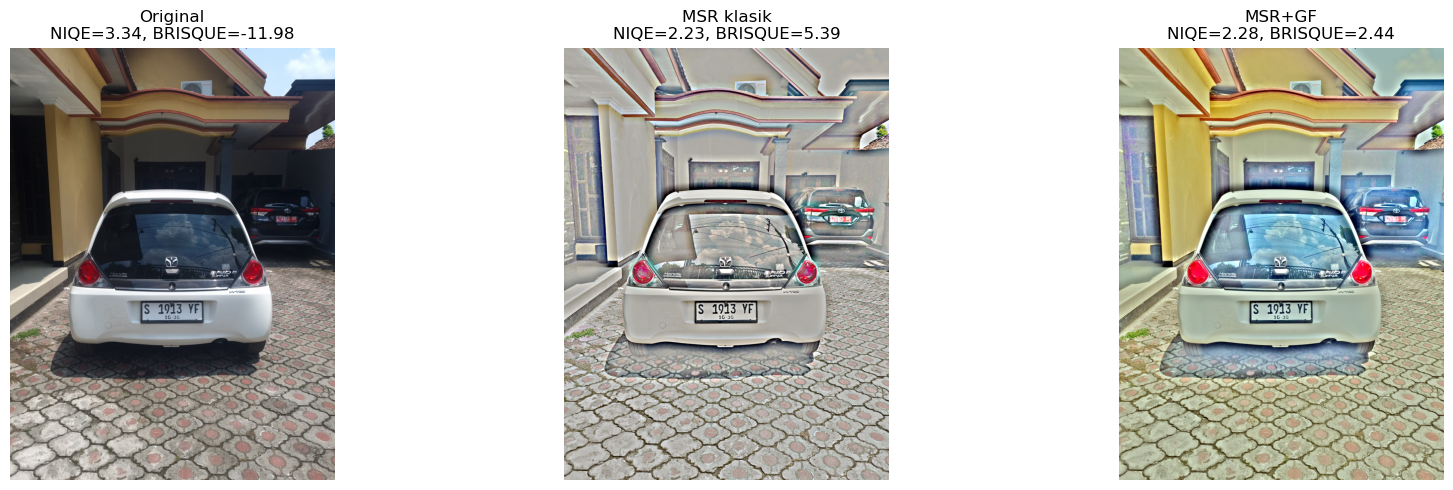

In [ ]:
# ================================================================
# Contoh penggunaan end-to-end: Original vs MSR vs MSR+GF pada citra cerah
# ================================================================

input_dir = Path("../ProcessedImages/Cerah")

# Ekstensi file gambar yang ingin kamu ikutkan
valid_exts = {".png"}

# Ambil semua path file gambar di folder tersebut
image_files = [p for p in input_dir.iterdir() if p.suffix.lower() in valid_exts]

if not image_files:
    raise FileNotFoundError(f"Tidak ada file gambar di folder: {input_dir}")

# Pilih satu gambar secara acak
random_img_path = random.choice(image_files)
print("Memakai gambar:", random_img_path.name)

# Pakai ini sebagai img_path
img_path = str(random_img_path)

# Baca citra (BGR)
img_orig = cv2.imread(img_path, cv2.IMREAD_COLOR)

# ---------- MSR klasik ----------
t0 = time.time()
img_msr = msr_basic_enhance(
    img_orig,
    scales=(15, 80, 250),
    max_kernel=151,
    apply_color_balance=True,
)
t1 = time.time()

# ---------- MSR + Guided Filter (metode baru) ----------
t2 = time.time()
img_msr_gf = retinex_msrgf_enhance(
    img_orig,
    sigmas=(15, 80, 250),
    guided_radius=16,
    guided_eps=1e-3,
    max_kernel=151,
    apply_color_balance=True,
)
t3 = time.time()

print("=== Citra Cerah ===")
print(f"Waktu pemrosesan MSR klasik : {t1 - t0:.3f} detik")
print(f"Waktu pemrosesan MSR+GF    : {t3 - t2:.3f} detik")

# ---------- Hitung kualitas (no-reference) ----------
niqe_orig    = compute_niqe(img_orig)
brisque_orig = compute_brisque(img_orig)

niqe_msr     = compute_niqe(img_msr)
brisque_msr  = compute_brisque(img_msr)

niqe_msr_gf     = compute_niqe(img_msr_gf)
brisque_msr_gf  = compute_brisque(img_msr_gf)

print("=== Quality scores (pyiqa) citra cerah ===")
print(f"Original - NIQE   : {niqe_orig:.4f}")
print(f"Original - BRISQUE: {brisque_orig:.4f}")
print(f"MSR      - NIQE   : {niqe_msr:.4f}")
print(f"MSR      - BRISQUE: {brisque_msr:.4f}")
print(f"MSR+GF   - NIQE   : {niqe_msr_gf:.4f}")
print(f"MSR+GF   - BRISQUE: {brisque_msr_gf:.4f}")

# ================================================================
# Visualisasi: Original vs MSR vs MSR+GF
# ================================================================
img_orig_rgb   = cv2.cvtColor(img_orig,   cv2.COLOR_BGR2RGB)
img_msr_rgb    = cv2.cvtColor(img_msr,    cv2.COLOR_BGR2RGB)
img_msr_gf_rgb = cv2.cvtColor(img_msr_gf, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_orig_rgb)
plt.title(f"Original\nNIQE={niqe_orig:.2f}, BRISQUE={brisque_orig:.2f}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_msr_rgb)
plt.title(f"MSR klasik\nNIQE={niqe_msr:.2f}, BRISQUE={brisque_msr:.2f}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_msr_gf_rgb)
plt.title(f"MSR+GF\nNIQE={niqe_msr_gf:.2f}, BRISQUE={brisque_msr_gf:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()

## Contoh Pada Citra Remang Random

Memakai gambar: 20251021_123216.png
=== Citra Remang ===
Waktu pemrosesan MSR klasik : 5.333 detik
Waktu pemrosesan MSR+GF    : 4.110 detik
=== Quality scores (pyiqa) citra remang ===
Original - NIQE   : 3.8727
Original - BRISQUE: 2.0219
MSR      - NIQE   : 3.4436
MSR      - BRISQUE: 16.9182
MSR+GF   - NIQE   : 3.8918
MSR+GF   - BRISQUE: 14.5893


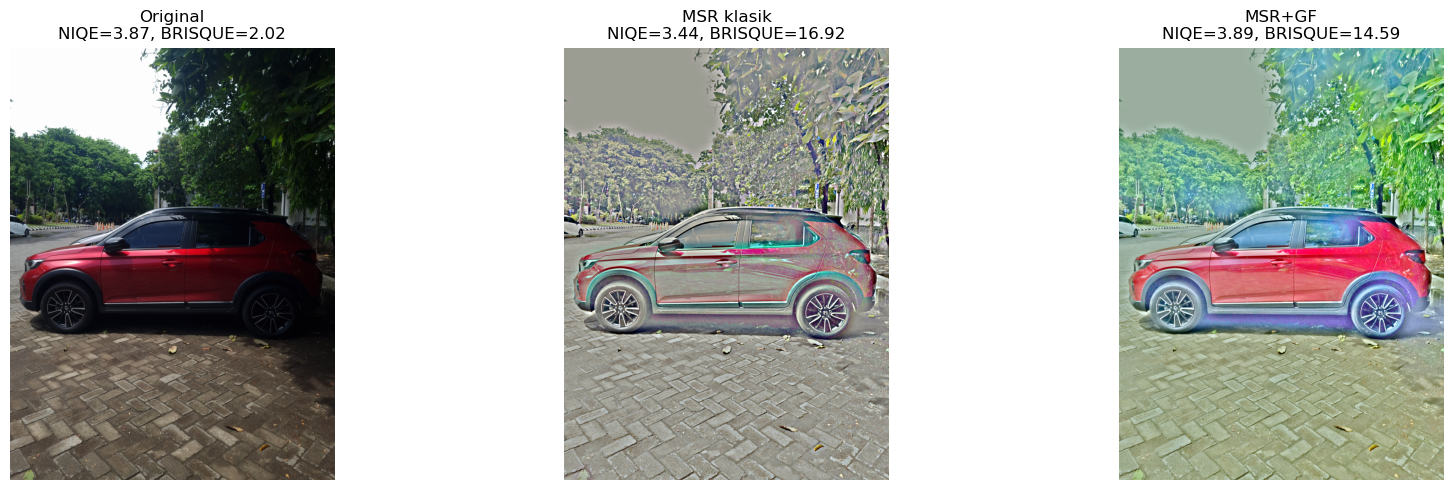

In [ ]:
# ================================================================
# Contoh penggunaan end-to-end: Original vs MSR vs MSR+GF pada citra remang
# ================================================================

input_dir = Path("../ProcessedImages/Remang")

# Ekstensi file gambar yang ingin kamu ikutkan
valid_exts = {".png"}

# Ambil semua path file gambar di folder tersebut
image_files = [p for p in input_dir.iterdir() if p.suffix.lower() in valid_exts]

if not image_files:
    raise FileNotFoundError(f"Tidak ada file gambar di folder: {input_dir}")

# Pilih satu gambar secara acak
random_img_path = random.choice(image_files)
print("Memakai gambar:", random_img_path.name)

# Pakai ini sebagai img_path
img_path = str(random_img_path)

# Baca citra (BGR)
img_orig = cv2.imread(img_path, cv2.IMREAD_COLOR)

# ---------- MSR klasik ----------
t0 = time.time()
img_msr = msr_basic_enhance(
    img_orig,
    scales=(15, 80, 250),
    max_kernel=151,
    apply_color_balance=True,
)
t1 = time.time()

# ---------- MSR + Guided Filter (metode baru) ----------
t2 = time.time()
img_msr_gf = retinex_msrgf_enhance(
    img_orig,
    sigmas=(15, 80, 250),
    guided_radius=16,
    guided_eps=1e-3,
    max_kernel=151,
    apply_color_balance=True,
)
t3 = time.time()

print("=== Citra Remang ===")
print(f"Waktu pemrosesan MSR klasik : {t1 - t0:.3f} detik")
print(f"Waktu pemrosesan MSR+GF    : {t3 - t2:.3f} detik")

# ---------- Hitung kualitas (no-reference) ----------
niqe_orig    = compute_niqe(img_orig)
brisque_orig = compute_brisque(img_orig)

niqe_msr     = compute_niqe(img_msr)
brisque_msr  = compute_brisque(img_msr)

niqe_msr_gf     = compute_niqe(img_msr_gf)
brisque_msr_gf  = compute_brisque(img_msr_gf)

print("=== Quality scores (pyiqa) citra remang ===")
print(f"Original - NIQE   : {niqe_orig:.4f}")
print(f"Original - BRISQUE: {brisque_orig:.4f}")
print(f"MSR      - NIQE   : {niqe_msr:.4f}")
print(f"MSR      - BRISQUE: {brisque_msr:.4f}")
print(f"MSR+GF   - NIQE   : {niqe_msr_gf:.4f}")
print(f"MSR+GF   - BRISQUE: {brisque_msr_gf:.4f}")

# ================================================================
# Visualisasi: Original vs MSR vs MSR+GF
# ================================================================
img_orig_rgb   = cv2.cvtColor(img_orig,   cv2.COLOR_BGR2RGB)
img_msr_rgb    = cv2.cvtColor(img_msr,    cv2.COLOR_BGR2RGB)
img_msr_gf_rgb = cv2.cvtColor(img_msr_gf, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_orig_rgb)
plt.title(f"Original\nNIQE={niqe_orig:.2f}, BRISQUE={brisque_orig:.2f}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_msr_rgb)
plt.title(f"MSR klasik\nNIQE={niqe_msr:.2f}, BRISQUE={brisque_msr:.2f}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_msr_gf_rgb)
plt.title(f"MSR+GF\nNIQE={niqe_msr_gf:.2f}, BRISQUE={brisque_msr_gf:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()

## Contoh Pada Citra Gelap Random

Memakai gambar: 20251016_181021.png
=== Citra Gelap ===
Waktu pemrosesan MSR klasik : 4.758 detik
Waktu pemrosesan MSR+GF    : 3.525 detik
=== Quality scores (pyiqa) citra gelap ===
Original - NIQE   : 4.5103
Original - BRISQUE: 5.6070
MSR      - NIQE   : 2.7967
MSR      - BRISQUE: 2.5893
MSR+GF   - NIQE   : 2.9156
MSR+GF   - BRISQUE: 0.2990


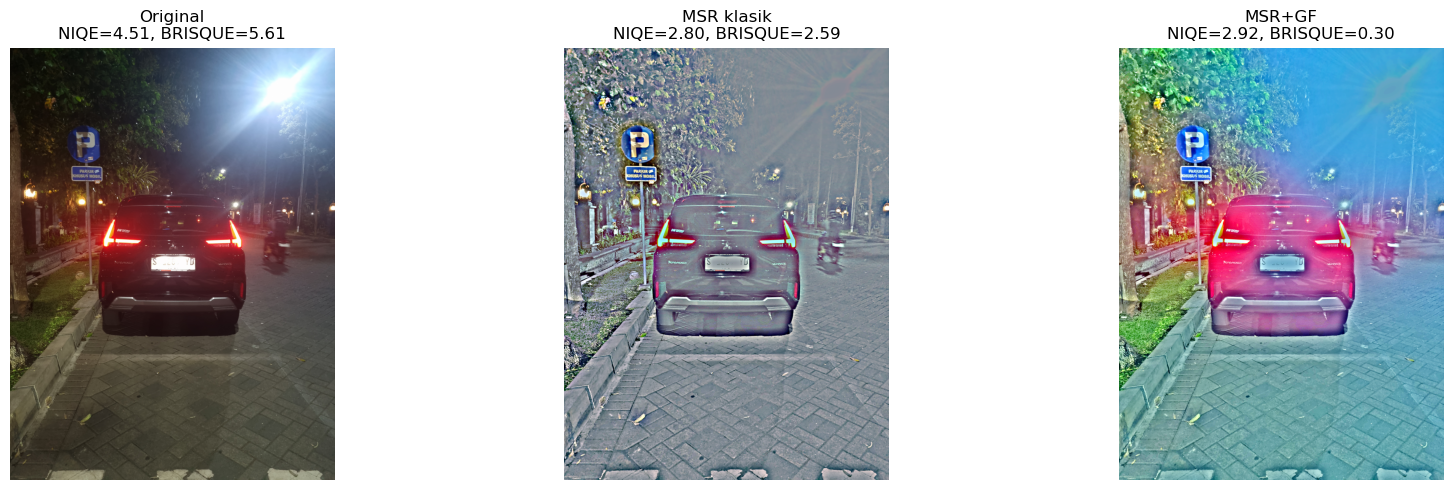

In [ ]:
# ================================================================
# Contoh penggunaan end-to-end: Original vs MSR vs MSR+GF pada citra gelap
# ================================================================

input_dir = Path("../ProcessedImages/Gelap")

# Ekstensi file gambar yang ingin kamu ikutkan
valid_exts = {".png"}

# Ambil semua path file gambar di folder tersebut
image_files = [p for p in input_dir.iterdir() if p.suffix.lower() in valid_exts]

if not image_files:
    raise FileNotFoundError(f"Tidak ada file gambar di folder: {input_dir}")

# Pilih satu gambar secara acak
random_img_path = random.choice(image_files)
print("Memakai gambar:", random_img_path.name)

# Pakai ini sebagai img_path
img_path = str(random_img_path)

# Baca citra (BGR)
img_orig = cv2.imread(img_path, cv2.IMREAD_COLOR)

# ---------- MSR klasik ----------
t0 = time.time()
img_msr = msr_basic_enhance(
    img_orig,
    scales=(15, 80, 250),
    max_kernel=151,
    apply_color_balance=True,
)
t1 = time.time()

# ---------- MSR + Guided Filter (metode baru) ----------
t2 = time.time()
img_msr_gf = retinex_msrgf_enhance(
    img_orig,
    sigmas=(15, 80, 250),
    guided_radius=16,
    guided_eps=1e-3,
    max_kernel=151,
    apply_color_balance=True,
)
t3 = time.time()

print("=== Citra Gelap ===")
print(f"Waktu pemrosesan MSR klasik : {t1 - t0:.3f} detik")
print(f"Waktu pemrosesan MSR+GF    : {t3 - t2:.3f} detik")

# ---------- Hitung kualitas (no-reference) ----------
niqe_orig    = compute_niqe(img_orig)
brisque_orig = compute_brisque(img_orig)

niqe_msr     = compute_niqe(img_msr)
brisque_msr  = compute_brisque(img_msr)

niqe_msr_gf     = compute_niqe(img_msr_gf)
brisque_msr_gf  = compute_brisque(img_msr_gf)

print("=== Quality scores (pyiqa) citra gelap ===")
print(f"Original - NIQE   : {niqe_orig:.4f}")
print(f"Original - BRISQUE: {brisque_orig:.4f}")
print(f"MSR      - NIQE   : {niqe_msr:.4f}")
print(f"MSR      - BRISQUE: {brisque_msr:.4f}")
print(f"MSR+GF   - NIQE   : {niqe_msr_gf:.4f}")
print(f"MSR+GF   - BRISQUE: {brisque_msr_gf:.4f}")

# ================================================================
# Visualisasi: Original vs MSR vs MSR+GF
# ================================================================
img_orig_rgb   = cv2.cvtColor(img_orig,   cv2.COLOR_BGR2RGB)
img_msr_rgb    = cv2.cvtColor(img_msr,    cv2.COLOR_BGR2RGB)
img_msr_gf_rgb = cv2.cvtColor(img_msr_gf, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_orig_rgb)
plt.title(f"Original\nNIQE={niqe_orig:.2f}, BRISQUE={brisque_orig:.2f}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_msr_rgb)
plt.title(f"MSR klasik\nNIQE={niqe_msr:.2f}, BRISQUE={brisque_msr:.2f}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_msr_gf_rgb)
plt.title(f"MSR+GF\nNIQE={niqe_msr_gf:.2f}, BRISQUE={brisque_msr_gf:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()

## Folder Citra Cerah

In [ ]:
# ================================================================
# Batch processing: proses semua gambar dalam folder + timing
# ================================================================

import time
from pathlib import Path

# 1. Atur folder input & output
input_dir = Path("../ProcessedImages/Cerah")
output_msr_dir = Path("../MSR_Result/Cerah")
output_msr_gf_dir = Path("../MSRGF_Result/Cerah")

# buat folder output jika belum ada
output_msr_dir.mkdir(parents=True, exist_ok=True)
output_msr_gf_dir.mkdir(parents=True, exist_ok=True)

# ekstensi gambar yang akan diproses
valid_exts = {".png"}

# 2. Siapkan penampung hasil metric
filenames = []
niqe_orig_list = []
brisque_orig_list = []
niqe_msr_list = []
brisque_msr_list = []
niqe_msr_gf_list = []
brisque_msr_gf_list = []

# --- penampung waktu komputasi ---
msr_times = []       # waktu msr_basic_enhance per citra
msr_gf_times = []    # waktu retinex_msrgf_enhance per citra

# 3. Loop semua file gambar di folder input
for img_path in sorted(input_dir.iterdir()):
    if img_path.suffix.lower() not in valid_exts:
        continue  # skip file non-gambar

    print(f"Memproses: {img_path.name}")
    img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        print(f"  Gagal membaca {img_path.name}, dilewati.")
        continue

    # ---------- MSR klasik ----------
    t0 = time.time()
    img_msr = msr_basic_enhance(
        img_bgr,
        scales=(15, 80, 250),
        max_kernel=151,
        apply_color_balance=True,
    )
    t1 = time.time()
    msr_times.append(t1 - t0)

    # ---------- MSR + Guided Filter (metode baru) ----------
    t2 = time.time()
    img_msr_gf = retinex_msrgf_enhance(
        img_bgr,
        sigmas=(15, 80, 250),
        guided_radius=16,
        guided_eps=1e-3,
        max_kernel=151,
        apply_color_balance=True,
    )
    t3 = time.time()
    msr_gf_times.append(t3 - t2)

    # --- Simpan hasil ke folder output ---
    out_msr_path = output_msr_dir / img_path.name
    out_msr_gf_path = output_msr_gf_dir / img_path.name

    cv2.imwrite(str(out_msr_path), img_msr)
    cv2.imwrite(str(out_msr_gf_path), img_msr_gf)

    # --- Hitung NIQE & BRISQUE (opsional: ini juga bisa ditiming terpisah) ---
    niqe_orig = compute_niqe(img_bgr)
    brisque_orig = compute_brisque(img_bgr)

    niqe_msr = compute_niqe(img_msr)
    brisque_msr = compute_brisque(img_msr)

    niqe_msr_gf = compute_niqe(img_msr_gf)
    brisque_msr_gf = compute_brisque(img_msr_gf)

    # simpan ke list
    filenames.append(img_path.name)
    niqe_orig_list.append(niqe_orig)
    brisque_orig_list.append(brisque_orig)
    niqe_msr_list.append(niqe_msr)
    brisque_msr_list.append(brisque_msr)
    niqe_msr_gf_list.append(niqe_msr_gf)
    brisque_msr_gf_list.append(brisque_msr_gf)

# 4. Hitung rata-rata metric
def safe_mean(x):
    return float(np.mean(x)) if len(x) > 0 else float("nan")

mean_niqe_orig = safe_mean(niqe_orig_list)
mean_brisque_orig = safe_mean(brisque_orig_list)
mean_niqe_msr = safe_mean(niqe_msr_list)
mean_brisque_msr = safe_mean(brisque_msr_list)
mean_niqe_msr_gf = safe_mean(niqe_msr_gf_list)
mean_brisque_msr_gf = safe_mean(brisque_msr_gf_list)

# 5. Hitung statistik waktu komputasi
mean_time_msr = safe_mean(msr_times)
mean_time_msr_gf = safe_mean(msr_gf_times)

total_time_msr = float(np.sum(msr_times)) if len(msr_times) > 0 else float("nan")
total_time_msr_gf = float(np.sum(msr_gf_times)) if len(msr_gf_times) > 0 else float("nan")

print("\n=== RATA-RATA METRIC UNTUK SELURUH CITRA CERAH ===")
print(f"Original - mean NIQE   : {mean_niqe_orig:.4f}")
print(f"Original - mean BRISQUE: {mean_brisque_orig:.4f}")
print(f"MSR      - mean NIQE   : {mean_niqe_msr:.4f}")
print(f"MSR      - mean BRISQUE: {mean_brisque_msr:.4f}")
print(f"MSR+GF   - mean NIQE   : {mean_niqe_msr_gf:.4f}")
print(f"MSR+GF   - mean BRISQUE: {mean_brisque_msr_gf:.4f}")

print("\n=== WAKTU KOMPUTASI (HANYA ENHANCEMENT) UNTUK CITRA CERAH ===")
print(f"MSR    - total waktu : {total_time_msr:.3f} detik, rata-rata per citra: {mean_time_msr:.3f} detik")
print(f"MSR+GF - total waktu : {total_time_msr_gf:.3f} detik, rata-rata per citra: {mean_time_msr_gf:.3f} detik")


Memproses: 20251017_105813.png
Memproses: 20251021_125609.png
Memproses: 20251021_130913.png
Memproses: 20251021_130933.png
Memproses: 20251025_101112.png
Memproses: IMG_1735.png
Memproses: IMG_1773.png
Memproses: IMG_1780.png
Memproses: IMG_1786.png
Memproses: IMG_1846.png
Memproses: IMG_1850.png
Memproses: IMG_1858.png
Memproses: IMG_1861.png
Memproses: IMG_1862.png
Memproses: IMG_1864.png

=== RATA-RATA METRIC UNTUK SELURUH CITRA CERAH ===
Original - mean NIQE   : 4.0462
Original - mean BRISQUE: 9.5292
MSR      - mean NIQE   : 2.7392
MSR      - mean BRISQUE: 10.0563
MSR+GF   - mean NIQE   : 2.7742
MSR+GF   - mean BRISQUE: 9.2648

=== WAKTU KOMPUTASI (HANYA ENHANCEMENT) UNTUK CITRA CERAH ===
MSR    - total waktu : 71.512 detik, rata-rata per citra: 4.767 detik
MSR+GF - total waktu : 51.372 detik, rata-rata per citra: 3.425 detik


Pada kelompok citra dengan pencahayaan cerah, baik MSR maupun MSR+GF menurunkan nilai rata-rata NIQE dari 4.05 menjadi sekitar 2.74–2.77, yang menunjukkan adanya peningkatan kualitas statistik global menurut metrik tersebut. Nilai NIQE MSR sedikit lebih rendah daripada MSR+GF, namun perbedaannya relatif kecil sehingga kualitas global keduanya dapat dianggap sebanding. Di sisi lain, rata-rata BRISQUE citra asli adalah 9.53 dan sedikit meningkat menjadi 10.06 setelah diterapkan MSR klasik, yang mengindikasikan adanya tambahan distorsi lokal. Metode MSR+GF justru menurunkan rata-rata BRISQUE menjadi 9.26, sehingga pada citra cerah metode ini mampu mengurangi distorsi lokal dan memberikan kompromi terbaik antara peningkatan naturalness (NIQE) dan preservasi tekstur (BRISQUE) dibanding MSR klasik. Selain itu waktu komputasi juga menunjukan bahwa metode MSR+GF memiliki rata-rata waktu komputasi yang lebih rendah dibandingkan dengan metode MSR klasik

## Folder Citra Remang

In [ ]:
# ================================================================
# Batch processing: proses semua gambar dalam folder + timing
# ================================================================

import time
from pathlib import Path

# 1. Atur folder input & output
input_dir = Path("../ProcessedImages/Remang")
output_msr_dir = Path("../MSR_Result/Remang")
output_msr_gf_dir = Path("../MSRGF_Result/Remang")

# buat folder output jika belum ada
output_msr_dir.mkdir(parents=True, exist_ok=True)
output_msr_gf_dir.mkdir(parents=True, exist_ok=True)

# ekstensi gambar yang akan diproses
valid_exts = {".png"}

# 2. Siapkan penampung hasil metric
filenames = []
niqe_orig_list = []
brisque_orig_list = []
niqe_msr_list = []
brisque_msr_list = []
niqe_msr_gf_list = []
brisque_msr_gf_list = []

# --- penampung waktu komputasi ---
msr_times = []       # waktu msr_basic_enhance per citra
msr_gf_times = []    # waktu retinex_msrgf_enhance per citra

# 3. Loop semua file gambar di folder input
for img_path in sorted(input_dir.iterdir()):
    if img_path.suffix.lower() not in valid_exts:
        continue  # skip file non-gambar

    print(f"Memproses: {img_path.name}")
    img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        print(f"  Gagal membaca {img_path.name}, dilewati.")
        continue

    # ---------- MSR klasik ----------
    t0 = time.time()
    img_msr = msr_basic_enhance(
        img_bgr,
        scales=(15, 80, 250),
        max_kernel=151,
        apply_color_balance=True,
    )
    t1 = time.time()
    msr_times.append(t1 - t0)

    # ---------- MSR + Guided Filter (metode baru) ----------
    t2 = time.time()
    img_msr_gf = retinex_msrgf_enhance(
        img_bgr,
        sigmas=(15, 80, 250),
        guided_radius=16,
        guided_eps=1e-3,
        max_kernel=151,
        apply_color_balance=True,
    )
    t3 = time.time()
    msr_gf_times.append(t3 - t2)

    # --- Simpan hasil ke folder output ---
    out_msr_path = output_msr_dir / img_path.name
    out_msr_gf_path = output_msr_gf_dir / img_path.name

    cv2.imwrite(str(out_msr_path), img_msr)
    cv2.imwrite(str(out_msr_gf_path), img_msr_gf)

    # --- Hitung NIQE & BRISQUE (opsional: ini juga bisa ditiming terpisah) ---
    niqe_orig = compute_niqe(img_bgr)
    brisque_orig = compute_brisque(img_bgr)

    niqe_msr = compute_niqe(img_msr)
    brisque_msr = compute_brisque(img_msr)

    niqe_msr_gf = compute_niqe(img_msr_gf)
    brisque_msr_gf = compute_brisque(img_msr_gf)

    # simpan ke list
    filenames.append(img_path.name)
    niqe_orig_list.append(niqe_orig)
    brisque_orig_list.append(brisque_orig)
    niqe_msr_list.append(niqe_msr)
    brisque_msr_list.append(brisque_msr)
    niqe_msr_gf_list.append(niqe_msr_gf)
    brisque_msr_gf_list.append(brisque_msr_gf)

# 4. Hitung rata-rata metric
def safe_mean(x):
    return float(np.mean(x)) if len(x) > 0 else float("nan")

mean_niqe_orig = safe_mean(niqe_orig_list)
mean_brisque_orig = safe_mean(brisque_orig_list)
mean_niqe_msr = safe_mean(niqe_msr_list)
mean_brisque_msr = safe_mean(brisque_msr_list)
mean_niqe_msr_gf = safe_mean(niqe_msr_gf_list)
mean_brisque_msr_gf = safe_mean(brisque_msr_gf_list)

# 5. Hitung statistik waktu komputasi
mean_time_msr = safe_mean(msr_times)
mean_time_msr_gf = safe_mean(msr_gf_times)

total_time_msr = float(np.sum(msr_times)) if len(msr_times) > 0 else float("nan")
total_time_msr_gf = float(np.sum(msr_gf_times)) if len(msr_gf_times) > 0 else float("nan")

print("\n=== RATA-RATA METRIC UNTUK SELURUH CITRA REMANG ===")
print(f"Original - mean NIQE   : {mean_niqe_orig:.4f}")
print(f"Original - mean BRISQUE: {mean_brisque_orig:.4f}")
print(f"MSR      - mean NIQE   : {mean_niqe_msr:.4f}")
print(f"MSR      - mean BRISQUE: {mean_brisque_msr:.4f}")
print(f"MSR+GF   - mean NIQE   : {mean_niqe_msr_gf:.4f}")
print(f"MSR+GF   - mean BRISQUE: {mean_brisque_msr_gf:.4f}")

print("\n=== WAKTU KOMPUTASI (HANYA ENHANCEMENT) UNTUK CITRA REMANG ===")
print(f"MSR    - total waktu : {total_time_msr:.3f} detik, rata-rata per citra: {mean_time_msr:.3f} detik")
print(f"MSR+GF - total waktu : {total_time_msr_gf:.3f} detik, rata-rata per citra: {mean_time_msr_gf:.3f} detik")


Memproses: 20251015_141612.png
Memproses: 20251015_141624.png
Memproses: 20251015_141747.png
Memproses: 20251015_141811.png
Memproses: 20251021_123158.png
Memproses: 20251021_123216.png
Memproses: 20251021_130831.png
Memproses: 20251025_101127.png
Memproses: 20251025_101142.png
Memproses: IMG_1769.png
Memproses: IMG_1787.png
Memproses: IMG_1788.png
Memproses: IMG_1795.png
Memproses: IMG_1797.png
Memproses: IMG_1801.png

=== RATA-RATA METRIC UNTUK SELURUH CITRA REMANG ===
Original - mean NIQE   : 3.9112
Original - mean BRISQUE: 5.5011
MSR      - mean NIQE   : 2.9998
MSR      - mean BRISQUE: 9.7493
MSR+GF   - mean NIQE   : 3.0709
MSR+GF   - mean BRISQUE: 7.8744

=== WAKTU KOMPUTASI (HANYA ENHANCEMENT) UNTUK CITRA REMANG ===
MSR    - total waktu : 77.683 detik, rata-rata per citra: 5.179 detik
MSR+GF - total waktu : 54.828 detik, rata-rata per citra: 3.655 detik


Pada kelompok citra remang, baik metode MSR maupun MSR+GF menurunkan nilai rata-rata NIQE dari 3,91 menjadi sekitar 3,00–3,07, yang menunjukkan bahwa keduanya mampu meningkatkan kualitas statistik global citra dibandingkan citra asli. MSR menghasilkan NIQE yang sedikit lebih rendah (lebih baik) daripada MSR+GF. Namun, dari sisi BRISQUE, citra asli memiliki nilai rata-rata 5,50 yang kemudian meningkat cukup tajam menjadi 9,75 setelah diterapkan MSR klasik, sehingga mengindikasikan bertambahnya distorsi lokal atau artefak pada hasil peningkatan. Metode MSR+GF masih menyebabkan kenaikan BRISQUE menjadi 7,87, tetapi kenaikan ini lebih kecil dibanding MSR klasik. Dengan demikian, pada citra remang metode MSR memberikan peningkatan naturalness yang lebih besar, sedangkan MSR+GF menawarkan kompromi yang lebih seimbang dengan distorsi lokal yang relatif lebih rendah dibanding MSR murni. Selain itu waktu komputasi juga menunjukan bahwa metode MSR+GF memiliki rata-rata waktu komputasi yang lebih rendah dibandingkan dengan metode MSR klasik

## Folder Citra Gelap

In [ ]:
# ================================================================
# Batch processing: proses semua gambar dalam folder + timing
# ================================================================

import time
from pathlib import Path

# 1. Atur folder input & output
input_dir = Path("../ProcessedImages/Gelap")
output_msr_dir = Path("../MSR_Result/Gelap")
output_msr_gf_dir = Path("../MSRGF_Result/Gelap")

# buat folder output jika belum ada
output_msr_dir.mkdir(parents=True, exist_ok=True)
output_msr_gf_dir.mkdir(parents=True, exist_ok=True)

# ekstensi gambar yang akan diproses
valid_exts = {".png"}

# 2. Siapkan penampung hasil metric
filenames = []
niqe_orig_list = []
brisque_orig_list = []
niqe_msr_list = []
brisque_msr_list = []
niqe_msr_gf_list = []
brisque_msr_gf_list = []

# --- penampung waktu komputasi ---
msr_times = []       # waktu msr_basic_enhance per citra
msr_gf_times = []    # waktu retinex_msrgf_enhance per citra

# 3. Loop semua file gambar di folder input
for img_path in sorted(input_dir.iterdir()):
    if img_path.suffix.lower() not in valid_exts:
        continue  # skip file non-gambar

    print(f"Memproses: {img_path.name}")
    img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        print(f"  Gagal membaca {img_path.name}, dilewati.")
        continue

    # ---------- MSR klasik ----------
    t0 = time.time()
    img_msr = msr_basic_enhance(
        img_bgr,
        scales=(15, 80, 250),
        max_kernel=151,
        apply_color_balance=True,
    )
    t1 = time.time()
    msr_times.append(t1 - t0)

    # ---------- MSR + Guided Filter (metode baru) ----------
    t2 = time.time()
    img_msr_gf = retinex_msrgf_enhance(
        img_bgr,
        sigmas=(15, 80, 250),
        guided_radius=16,
        guided_eps=1e-3,
        max_kernel=151,
        apply_color_balance=True,
    )
    t3 = time.time()
    msr_gf_times.append(t3 - t2)

    # --- Simpan hasil ke folder output ---
    out_msr_path = output_msr_dir / img_path.name
    out_msr_gf_path = output_msr_gf_dir / img_path.name

    cv2.imwrite(str(out_msr_path), img_msr)
    cv2.imwrite(str(out_msr_gf_path), img_msr_gf)

    # --- Hitung NIQE & BRISQUE (opsional: ini juga bisa ditiming terpisah) ---
    niqe_orig = compute_niqe(img_bgr)
    brisque_orig = compute_brisque(img_bgr)

    niqe_msr = compute_niqe(img_msr)
    brisque_msr = compute_brisque(img_msr)

    niqe_msr_gf = compute_niqe(img_msr_gf)
    brisque_msr_gf = compute_brisque(img_msr_gf)

    # simpan ke list
    filenames.append(img_path.name)
    niqe_orig_list.append(niqe_orig)
    brisque_orig_list.append(brisque_orig)
    niqe_msr_list.append(niqe_msr)
    brisque_msr_list.append(brisque_msr)
    niqe_msr_gf_list.append(niqe_msr_gf)
    brisque_msr_gf_list.append(brisque_msr_gf)

# 4. Hitung rata-rata metric
def safe_mean(x):
    return float(np.mean(x)) if len(x) > 0 else float("nan")

mean_niqe_orig = safe_mean(niqe_orig_list)
mean_brisque_orig = safe_mean(brisque_orig_list)
mean_niqe_msr = safe_mean(niqe_msr_list)
mean_brisque_msr = safe_mean(brisque_msr_list)
mean_niqe_msr_gf = safe_mean(niqe_msr_gf_list)
mean_brisque_msr_gf = safe_mean(brisque_msr_gf_list)

# 5. Hitung statistik waktu komputasi
mean_time_msr = safe_mean(msr_times)
mean_time_msr_gf = safe_mean(msr_gf_times)

total_time_msr = float(np.sum(msr_times)) if len(msr_times) > 0 else float("nan")
total_time_msr_gf = float(np.sum(msr_gf_times)) if len(msr_gf_times) > 0 else float("nan")

print("\n=== RATA-RATA METRIC UNTUK SELURUH CITRA GELAP ===")
print(f"Original - mean NIQE   : {mean_niqe_orig:.4f}")
print(f"Original - mean BRISQUE: {mean_brisque_orig:.4f}")
print(f"MSR      - mean NIQE   : {mean_niqe_msr:.4f}")
print(f"MSR      - mean BRISQUE: {mean_brisque_msr:.4f}")
print(f"MSR+GF   - mean NIQE   : {mean_niqe_msr_gf:.4f}")
print(f"MSR+GF   - mean BRISQUE: {mean_brisque_msr_gf:.4f}")

print("\n=== WAKTU KOMPUTASI (HANYA ENHANCEMENT) UNTUK CITRA GELAP ===")
print(f"MSR    - total waktu : {total_time_msr:.3f} detik, rata-rata per citra: {mean_time_msr:.3f} detik")
print(f"MSR+GF - total waktu : {total_time_msr_gf:.3f} detik, rata-rata per citra: {mean_time_msr_gf:.3f} detik")


Memproses: 20251016_180732.png
Memproses: 20251016_180816.png
Memproses: 20251016_181003.png
Memproses: 20251016_181021.png
Memproses: 20251016_181036.png
Memproses: 20251016_202315.png
Memproses: 20251016_202332.png
Memproses: 20251016_203001.png
Memproses: 20251019_173623.png
Memproses: 20251019_173639.png
Memproses: 20251019_173700.png
Memproses: 20251019_173712.png
Memproses: 20251019_173729.png
Memproses: 20251019_173810.png
Memproses: 20251019_173838.png

=== RATA-RATA METRIC UNTUK SELURUH CITRA GELAP ===
Original - mean NIQE   : 4.5611
Original - mean BRISQUE: 7.4010
MSR      - mean NIQE   : 2.7592
MSR      - mean BRISQUE: 4.5357
MSR+GF   - mean NIQE   : 2.8268
MSR+GF   - mean BRISQUE: 3.8130

=== WAKTU KOMPUTASI (HANYA ENHANCEMENT) UNTUK CITRA GELAP ===
MSR    - total waktu : 72.081 detik, rata-rata per citra: 4.805 detik
MSR+GF - total waktu : 53.745 detik, rata-rata per citra: 3.583 detik


Pada kelompok citra gelap, baik MSR maupun MSR+GF memberikan peningkatan kualitas yang paling signifikan dibanding dua kategori sebelumnya. Nilai rata-rata NIQE turun dari 4,56 pada citra asli menjadi sekitar 2,76 untuk MSR dan 2,83 untuk MSR+GF, yang menunjukkan bahwa kedua metode secara efektif meningkatkan naturalness citra gelap. Dari sisi BRISQUE, rata-rata skor berkurang dari 7,40 menjadi 4,54 pada MSR dan 3,81 pada MSR+GF, sehingga di kelas citra gelap tidak hanya kualitas global membaik, tetapi juga distorsi lokal dan noise berkurang cukup besar. MSR menghasilkan NIQE terbaik, sedangkan MSR+GF memberikan nilai BRISQUE terendah, sehingga metode MSR+GF dapat dianggap memberikan kompromi terbaik antara peningkatan pencahayaan, pengurangan noise, dan preservasi detail pada citra dengan intensitas pencahayaan yang sangat rendah. Selain itu waktu komputasi juga menunjukan bahwa metode MSR+GF memiliki rata-rata waktu komputasi yang lebih rendah dibandingkan dengan metode MSR klasik